In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import popoff
from average_traces import AverageTraces, SingleCells
from Session import Session, SessionLite
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from matplotlib import gridspec
import seaborn as sns
import copy
from statsmodels.stats import multitest

from sklearn.linear_model import LinearRegression
from scipy import stats

In [6]:
# global plotting params
plt.style.use('ggplot')
# gg plot colors are nice but want seaborn style
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'xx-large',
          'text.usetex':False,
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

figure_path = '/home/jrowland/mnt/qnap/Figures/bois'

In [7]:
params = {'legend.fontsize': 'xx-large',
          'text.usetex':False,
         'axes.labelsize': 'medium',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

In [8]:
dff = AverageTraces('dff')
dff.build_trace_dict()

(373, 51)
(10, 51)
(373, 51)
(10, 51)


In [9]:
# spks = AverageTraces('spks')
# spks.build_trace_dict()

In [10]:
# denoised = AverageTraces('denoised_flu')
# denoised.build_trace_dict()

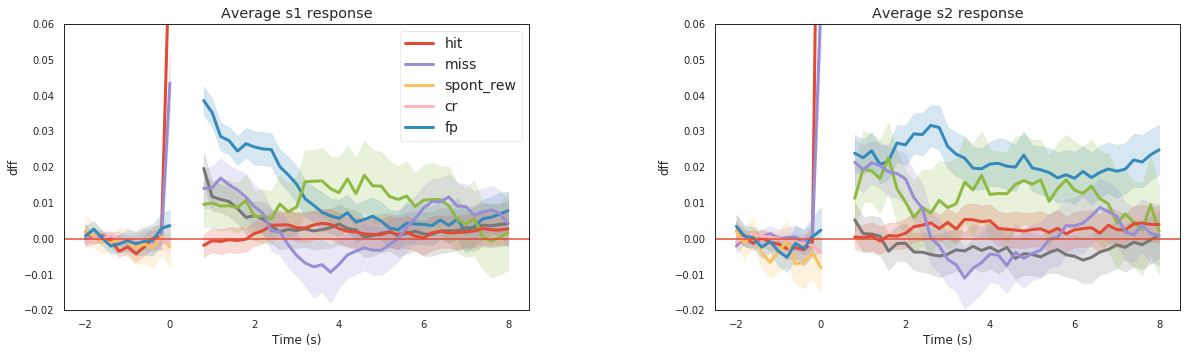

In [14]:
plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(3,1, hspace=0.4, wspace=0.8)

dff.s1s2_plot((-0.02, 0.06), outer[0], stim_type='test', balance=False)
# denoised.s1s2_plot((-0.02, 0.06), outer[1], stim_type='test', balance=False)
# spks.s1s2_plot((-0.005, 0.005), outer[2], stim_type='test', balance=False)

In [8]:
dff.sessions

{0: instance Mouse RL070, run 28 of Session class,
 1: instance Mouse RL070, run 29 of Session class,
 2: instance Mouse J048, run 27 of Session class,
 3: instance Mouse J048, run 28 of Session class,
 4: instance Mouse J048, run 29 of Session class,
 5: instance Mouse J048, run 30 of Session class,
 6: instance Mouse J048, run 32 of Session class,
 7: instance Mouse J064, run 10 of Session class,
 8: instance Mouse J064, run 11 of Session class,
 9: instance Mouse J064, run 14 of Session class,
 10: instance Mouse J063, run 8 of Session class,
 11: instance Mouse J063, run 9 of Session class,
 12: instance Mouse RL048, run 23 of Session class,
 13: instance Mouse RL048, run 24 of Session class,
 14: instance Mouse RL048, run 25 of Session class,
 15: instance Mouse RL048, run 28 of Session class,
 16: instance Mouse RL048, run 29 of Session class,
 17: instance Mouse J065, run 10 of Session class,
 18: instance Mouse J065, run 11 of Session class}

In [9]:
dff = SingleCells('dff')
s1s2_dict = dff.s1s2_dict

(373, 51)


/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:5216: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(373, 51)
(10, 51)
(373, 51)
(373, 51)
(373, 51)
(373, 51)
(10, 51)
(373, 51)
(373, 51)
(10, 51)
(373, 51)
(373, 51)
(373, 51)
(373, 51)
(10, 51)


In [16]:
def get_range(session, plot=False):

    if True or session.mouse == 'RL048' or session.mouse == 'J048':
        # Need to be same length to do wilcoxon
        # Rob does 500ms  so 3 ish frames
        n_frames = 3
        pre_end = 16
        post_start = 30
        
    else:
        # 3 frames above so 15 frames here
        n_frames = 15
        pre_end = 100
        post_start = 160

    pre_range = [pre_end-n_frames, pre_end]
    post_range = [post_start, post_start+n_frames]

    if plot:
        plt.plot(np.mean(session.behaviour_trials, (0,1)))

        for pre, post in zip(post_range, pre_range):
            plt.axvline(pre, color='blue')
            plt.axvline(post, color='red')
    
    return pre_range, post_range

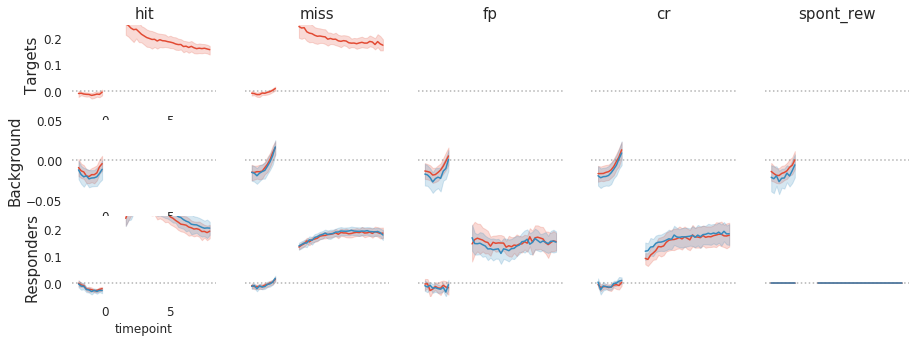

In [17]:
plt.figure(figsize=(15,5))


n_plots = 0
for cell_type in ['Targets', 'Background', 'Responders']:
    
    if cell_type == 'Target':
        ylim = (0,0.)
    elif cell_type == 'Background':
        ylim = (-0.05, 0.05)
    else:
        ylim = (-0.05, 0.25)
        
    for trial_type in ['hit', 'miss', 'fp', 'cr', 'spont_rew']:
        
        n_plots += 1 
        plt.subplot(3, 5, n_plots)
        plt.ylim(ylim)
        
        sns.despine(left=True, bottom=True)
        
        if cell_type == 'Targets':
            plt.gca().set_title(trial_type, fontsize=15)
            
        
        plt.axhline(y=0, linestyle=':', color='gray', alpha=0.6)
        for idx, region in enumerate(['s1', 's2']):
            
            trace = s1s2_dict[region][cell_type][trial_type]
            
            if n_plots == 5:
                label = region
            else:
                label = None
                
            ax = sns.lineplot(data=trace[trace['timepoint']<0], x='timepoint', y='dff', label=label,
                              color=colors[idx])
            
            # 1.5 If youre plotting easy trials
            ax2 = sns.lineplot(data=trace[trace['timepoint']>=1.5], x='timepoint', y='dff', label=None,
                              color=colors[idx])
            
        if trial_type == 'hit':
            ylabel=cell_type
        else:
            ylabel=None
            ax.set(xlabel=None, xticklabels=[], yticklabels=[])
            
        ax.set_ylabel(ylabel, fontsize=15)
            
            
plt.savefig(os.path.join(figure_path, 'averageTracesEasy.pdf'),bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'averageTracesEasy.png'),bbox_inches="tight")
#sns.lineplot(data=trace_dict['Background']['miss'], x='timepoint', y='dff')

In [13]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    
    
    doesnt work with 2d yet
    """
    average = np.average(values, weights=weights, axis=1)
    # Wrong
    variance = np.array([np.average((value-average)**2, weights=weights) for value in values])
    
    
    return (average, math.sqrt(variance))

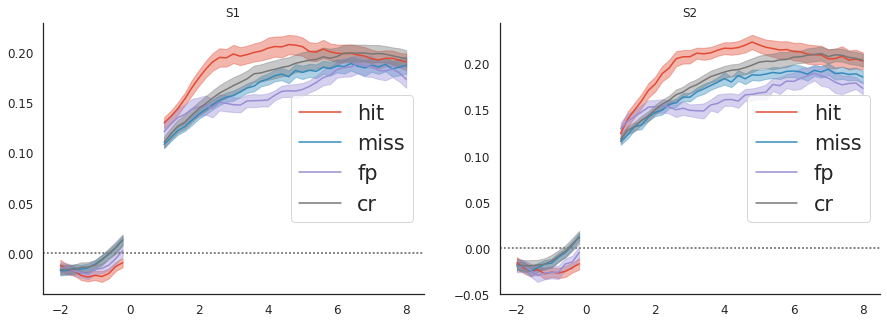

In [18]:
plt.figure(figsize=(15,5))

outcomes = ['hit', 'miss', 'fp', 'cr']

for idx, region in enumerate(['s1', 's2']):
    
    ax = plt.subplot(1,2,idx+1)
    
    color_idx = 0
    
    for outcome in outcomes:
        
        trace = s1s2_dict[region]['Background'][outcome]

        if outcome in ['hit', 'miss']:
            weight = np.array([sum(np.logical_and(session.photostim==1, session.outcome==outcome)) 
                               for session in dff.sessions.values()])
            
        else:
            weight = np.array([sum(session.outcome==outcome) for session in dff.sessions.values()])
            
        no_weighting = False
                
        if no_weighting:
            weight = np.ones(len(weight))

        t_len = len(dff.times_use)
        reshaped = trace['dff'].to_numpy().reshape((t_len, int(len(trace['dff'])/t_len)), order='F')
        
        # You need to look into why this has NaNs
        nonnan_idxs = np.where(~np.isnan(np.mean(reshaped, axis=0)))[0]

        weighted_avg = np.average(reshaped[:, nonnan_idxs], weights=weight[nonnan_idxs], axis=1)
        
        # Not yet weighted
        ci = np.nanstd(reshaped, axis=1) / math.sqrt(reshaped.shape[1])

        times = dff.times_use

        for ii, t_idx in enumerate([times<0, times>=1]):  # Two plots to make the gap
            
            if ii ==0:
                label = outcome
            else:
                label = None
            
            plt.plot(times[t_idx], weighted_avg[t_idx], color=colors[color_idx], linewidth=1.5, label=label)
            plt.fill_between(times[t_idx], weighted_avg[t_idx]-ci[t_idx], 
                             weighted_avg[t_idx] + ci[t_idx], alpha=0.4, color=colors[color_idx])

        plt.axhline(y=0, linestyle=':', color='gray', alpha=0.8)
        
        color_idx += 1

        # Fills whole vector with same number for some reason
        #ci = sns.utils.ci(sns.algorithms.bootstrap(reshaped, axis=1), axis=0)[0,:]

        #plt.ylim((-0.07, 0.09))

        plt.title(region.upper())

        plt.legend()
        
        # WHY ARE THERE FUCKING NANS IN THIS PLOT
        
plt.savefig(os.path.join(figure_path, 'wooooooo_positivefook.pdf'),bbox_inches="tight")


In [53]:
dff.sessions

{0: instance Mouse RL070, run 28 of Session class,
 1: instance Mouse RL070, run 29 of Session class,
 2: instance Mouse J048, run 27 of Session class,
 3: instance Mouse J048, run 28 of Session class,
 4: instance Mouse J048, run 29 of Session class,
 5: instance Mouse J048, run 30 of Session class,
 6: instance Mouse J048, run 32 of Session class,
 7: instance Mouse J064, run 10 of Session class,
 8: instance Mouse J064, run 11 of Session class,
 9: instance Mouse J064, run 14 of Session class,
 11: instance Mouse J063, run 9 of Session class,
 12: instance Mouse RL048, run 23 of Session class,
 13: instance Mouse RL048, run 24 of Session class,
 14: instance Mouse RL048, run 25 of Session class,
 15: instance Mouse RL048, run 28 of Session class,
 16: instance Mouse RL048, run 29 of Session class,
 18: instance Mouse J065, run 11 of Session class}

In [19]:
def prepare_population(arr, frames, mean=True):
    
    arr_frames = arr[:, :, range(*frames)] 
    if mean:
        return np.mean(arr_frames, 2)
    else:
        return np.reshape(arr_frames, (arr_frames.shape[0], arr_frames.shape[1] * arr_frames.shape[2]))

In [20]:
def get_sig_pass(session, fdr_rate=0.1, ps_type=1, subset=[150], outcome='all',
                 cells='all', mask_targets=False, direction='both'):
    
    #arr = session.behaviour_trials[:, session.photostim==ps_type, :]
    
    if mask_targets:
        behaviour_trials = np.ma.array(session.behaviour_trials, mask=session.is_target, copy=True)
    else:
        behaviour_trials = session.behaviour_trials
    
    if len(subset) == 1:
        trials_use = session.trial_subsets == subset[0]
    else:
        trial_bools = [session.trial_subsets==sub for sub in subset]
        trials_use = np.logical_or.reduce(trial_bools)
        
    if outcome != 'all':
        trials_use = np.logical_and(trials_use, session.outcome==outcome)
        
    if outcome =='spont_rew':
        arr = session.pre_rew_trials
    else:
        arr = behaviour_trials[:, trials_use, :]
    
#     if cells == 's1':
#         arr = arr[session.s1_bool, :, :]
#     elif cells == 's2':
#         arr = arr[session.s2_bool, :, :]
        
    pre_frames, post_frames = get_range(session, plot=False)

    pre_array = prepare_population(copy.deepcopy(arr), pre_frames)
    post_array = prepare_population(copy.deepcopy(arr), post_frames)
    
    
    if outcome != 'spont_rew' and mask_targets==True:  # This can be made less shit
        p_vals = [stats.wilcoxon(pre, post)[1] for pre, post in zip(pre_array, post_array)
                 if not pre.mask.all()]
    else:
        p_vals = [stats.wilcoxon(pre, post)[1] for pre, post in zip(pre_array, post_array)]
        
    p_vals = np.array(p_vals)

    sig_cells, correct_pval, _, _ = multitest.multipletests(p_vals, alpha=fdr_rate, method='fdr_bh',
                                                            is_sorted=False, returnsorted=False)
    
    positive = np.mean(post_array, 1) - np.mean(pre_array, 1) > 0
    
    if direction == 'positive':
        sig_cells = np.logical_and(sig_cells, positive)
    elif direction == 'negative': 
        sig_cells = np.logical_and(sig_cells, ~positive)
    
    if cells == 'all':
        return sig_cells
    elif cells == 's1':
        return np.logical_and(sig_cells, session.s1_bool)
    elif cells == 's2':
        return np.logical_and(sig_cells, session.s2_bool)

(8, 51)
hit
8
(4, 51)
miss
4
(6, 51)
cr
6
(5, 51)
fp
5
(8, 51)
hit
8
(3, 51)
miss
3
(8, 51)
cr
8
(5, 51)
fp
5


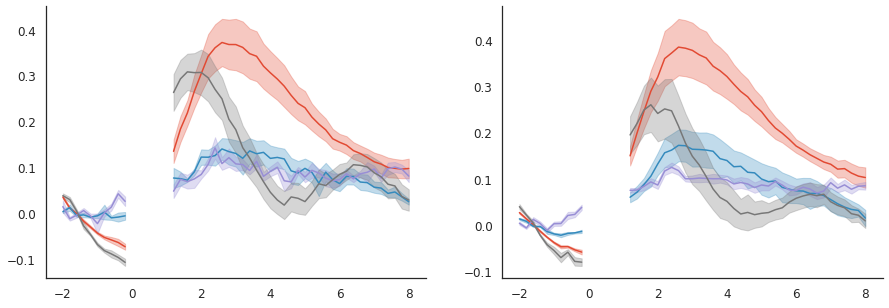

In [21]:
plt.figure(figsize=(15,5))

direction = 'up'
only_responders = True

for idx, region in enumerate(['s1', 's2']):

    plt.subplot(1,2,idx+1)
    
    color_idx = 0
    
    for outcome in ['hit', 'miss', 'cr', 'fp']:
#     for outcome in ['hit']:
    
        stacked_trials = []

        for session in dff.sessions.values():

            if outcome in ['hit', 'miss']:
                trial_bool = np.logical_and(session.outcome==outcome, session.photostim==1)
            else:
                trial_bool = session.outcome==outcome
            
            behaviour_trials = session.behaviour_trials
            
            baseline_frames = np.where((session.filter_ps_time>=-2) & 
                                       (session.filter_ps_time<-1))[0]
            baseline = np.mean(behaviour_trials[:, :, baseline_frames], 2)
            behaviour_trials = behaviour_trials - baseline[:,:,np.newaxis]

            arr = np.ma.array(behaviour_trials, mask=session.is_target)
            
            if only_responders:
                # This does not include outcome!!
                #cell_bool = dff.get_sig_pass(session, 0.1, subset=[20,30,40,50], cells=region)
                
                if outcome in ['hit', 'miss']:
                    cell_bool = get_sig_pass(session, 0.1, subset=[20,30,40,50], cells=region, outcome=outcome)
                else:
                    cell_bool = get_sig_pass(session, 0.1, subset=[0], cells=region, outcome=outcome)
            else:
                if region == 's1':
                    cell_bool = session.s1_bool
                else:
                    cell_bool = session.s2_bool
            
            arr = arr[cell_bool, :, :]
            arr = arr[:, trial_bool, :]
            arr = arr[:, :, session.frames_use]
            
            pre = dff.times_use < 0
            post = dff.times_use > 1
            subbed = np.mean(arr[:, :, post], (1,2)) - np.mean(arr[:, :, pre], (1,2))

            up = subbed > 0
            down = subbed < 0

            if direction == 'up':
                arr = arr[up, :, :]
            elif direction == 'down':
                arr = arr[down, :, :]

            if arr.shape[0] == 0:
                continue
            else:
                stacked_trials.append(np.mean(arr, (0,1)))

        if outcome in ['hit', 'miss']:
            weight = np.array([sum(np.logical_and(session.photostim==1, session.outcome==outcome)) 
                               for session in dff.sessions.values()])
        else:
            weight = np.array([sum(session.outcome==outcome) for session in dff.sessions.values()])
        
#         weight = np.ones(len(weight))
            
#         stacked_trials = np.concatenate(np.array(stacked_trials))
        stacked_trials = np.array(stacked_trials)
        print(stacked_trials.shape)
        
        x_axis = dff.times_use

        mean = np.mean(stacked_trials, 0)
#         mean = np.average(stacked_trials, weights=weight, axis=0)
        
        print(outcome)
        print(stacked_trials.shape[0])
        sem = np.std(stacked_trials, 0) / math.sqrt(stacked_trials.shape[0])
        
        label = outcome
        
        for frames in [pre, post]:
            
            plt.plot(x_axis[frames], mean[frames], label=label,
                     color=colors[color_idx])
            
            plt.fill_between(x_axis[frames], mean[frames]-sem[frames],
                             mean[frames]+sem[frames], color=colors[color_idx], alpha=0.3)
            label = None
            
        color_idx += 1
        
    
    if idx == 0:
        ylims = plt.gca().get_ylim()
    else:
        ylims = plt.gca().set_ylim()
    
    if direction == 'down':
        plt.ylim(-0.3, 0.05)
        
plt.savefig(os.path.join(figure_path, f'average_bois_{direction}.pdf'),bbox_inches="tight")

In [22]:
outcome = 'hit'
ps_type = 2

running_n = 0
n = 0
rob_mean = []
for session in dff.sessions.values():
    
    n_trial_in_session = sum(np.logical_and(session.photostim==ps_type, session.outcome==outcome))
    rob_mean.append(np.mean(reshaped[:, running_n:n_trial_in_session+running_n], 1))
    
    running_n += n_trial_in_session
    
rob_mean = np.array(rob_mean)

/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [23]:
def get_range(session, plot=False):

    if session.mouse == 'RL048' or session.mouse == 'J048':
        # Need to be same length to do wilcoxon
        # Rob does 500ms  so 3 ish frames
        n_frames = 3
        pre_range = [16-n_frames, 16]
        post_range = [30, 30+n_frames]
    else:
        # 3 frames above so 15 frames here
        n_frames = 15
        pre_range = [100-n_frames, 100]
        post_range = [160, 160+n_frames]

    if plot:
        plt.figure()
        plt.plot(np.mean(session.behaviour_trials, (0,1)))

        for pre, post in zip(post_range, pre_range):
            plt.axvline(pre, color='blue')
            plt.axvline(post, color='red')
    
    return pre_range, post_range

In [24]:
sessions = dff.sessions
session = sessions[2]

In [77]:
def get_injected_propagated(session, region='s1', n_cells='all', outcome='hit', direction='positive'):

    behaviour_trials = session.behaviour_trials
    
    
    if outcome in ['hit', 'miss']:
        trial_mask = np.logical_and(session.outcome==outcome, session.photostim==1)
    else:
        raise NotYetImplementError('As no targets')

    pre_range, post_range = get_range(session)

    targets = np.ma.array(behaviour_trials, mask=~session.is_target, copy=True)
    
    background = np.ma.array(behaviour_trials, mask=session.is_target, copy=True)

    injected = targets[:, :, post_range].mean(2) - targets[:, :, pre_range].mean(2)
    
    propagated = background[:, :, post_range].mean(2) - background[:, :, pre_range].mean(2) 

    if n_cells == 'all':
        injected = injected[:, np.logical_not(session.photostim==0)]
        propagated = propagated[:, np.logical_not(session.photostim==0)]
    else:
        #injected = injected[:, np.logical_and(session.trial_subsets==n_cells, session.outcome==outcome)]
        injected = injected[:, np.logical_and(np.isin(session.trial_subsets, n_cells),
                                              session.outcome==outcome)]
        #propagated = propagated[:, np.logical_and(session.trial_subsets==n_cells, session.outcome==outcome)]
        propagated = propagated[:, np.logical_and(np.isin(session.trial_subsets, n_cells),
                                               session.outcome==outcome)]
    
    if region == 's1':
        cell_bool = session.s1_bool
    elif region == 's2':
        cell_bool = session.s2_bool
    else:
        cell_bool = np.repeat(True, len(session.s1_bool))
    
    # This is cells that pass on hits and misses, not either or
    #responders = dff.get_sig_pass(session, 0.1, subset=[20,30,40,50], cells=region)
    
    if outcome in ['hit', 'miss']:
        responders = get_sig_pass(session, 0.1, subset=[20,30,40,50], cells=region, outcome=outcome)
    else:
        responders = get_sig_pass(session, 0.1, subset=[0], cells=region, outcome=outcome)
        
#     propagated = propagated[cell_bool, :]  # Use me if just background not responders
    propagated = propagated[responders, :]

    if direction == 'positive':
        propagated = propagated[np.mean(propagated, 1) > 0, :]
    elif direction == 'negative':
        propagated = propagated[np.mean(propagated, 1) < 0, :]

    # Cell sum
    injected = injected.sum(0)
    propagated = propagated.sum(0)

    
    if len(injected) == 0 or len(propagated) == 0 or injected.mask.all() or propagated.mask.all():
        return [], []
    else:
#         print(injected)
#         print(propagated)
        return injected, propagated

/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


hit s1 r square = 0.35081801667300255, gradient = 0.8395084908860698, p=1.8182099019119757e-05


/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


miss s1 r square = 0.39691400633309754, gradient = 0.5343776575494686, p=0.00671552497512525


/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


hit s2 r square = 0.5328421107977006, gradient = 1.8589023566976381, p=1.2727711370356468e-08


/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


miss s2 r square = 0.3729953251101465, gradient = 0.8697802192827391, p=0.009209921288507852


/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


hit s1 r square = 0.02022691931308956, gradient = -0.09523724331649695, p=0.3513613227225588


/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


miss s1 r square = 0.2980887185402558, gradient = -0.48771865074395776, p=0.01907917318884126


/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


hit s2 r square = 0.31720256426470145, gradient = -0.35812987400194546, p=5.629592942097279e-05


/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrowland/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


miss s2 r square = 0.3031281547170117, gradient = -0.48812534193776025, p=0.017897026781694914


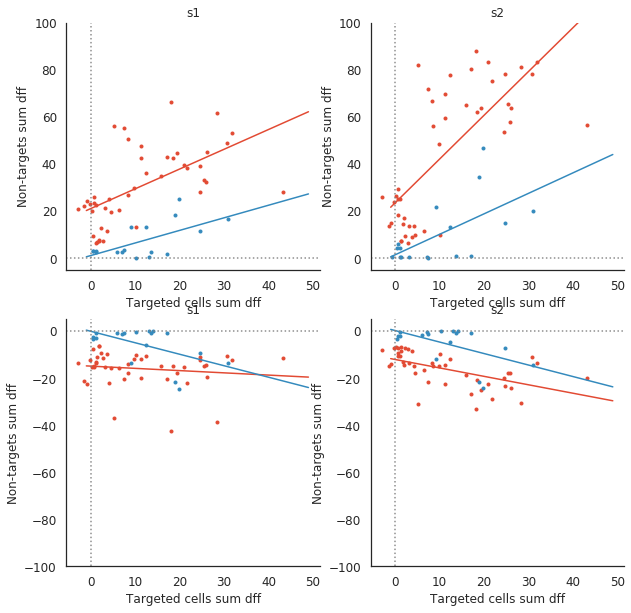

In [78]:
plot_all_trials = False

plt.figure(figsize=(10,10))

# This needs to be modularised, and better cached to improve speed and avoid 
# excessive nested for loops

n_plots = 0

for direction in ['positive', 'negative']:
    for region_idx, region in enumerate(['s1', 's2']):
        
        
        n_plots += 1
        
        plt.subplot(2,2,n_plots)
        plt.title(region)
        
        if direction == 'positive':
            y_text = 60
        else:
            y_text = -60
            
        for idx, outcome in enumerate(['hit', 'miss']):
        
            if outcome == 'hit':
                x_text = 20
                col = colors[0]
            else:
                x_text = 42
                col = colors[1]
                
            regress_x = []
            regress_y = []
                
            for n_cells in [[5,10],[20,30],[40,50]]:
#             for n_cells in [[5,10]]:

                injected_all = []
                propagated_all = []

                for session in sessions.values():
                    
                    if session.behaviour_trials.shape[0] < 200:
                        continue
                        
                    else:
                        injected, propagated = get_injected_propagated(session, region=region, 
                                                                       n_cells=n_cells, outcome=outcome,
                                                                       direction=direction)
                        injected_all.append(injected)
                        propagated_all.append(propagated)

                if plot_all_trials:
                    injected_all = np.concatenate(injected_all)
                    propagated_all = np.concatenate(propagated_all)
                else:
                    injected_all = [np.mean(inj) for inj in injected_all if len(inj) > 0]
                    propagated_all = [np.mean(prop) for prop in propagated_all if len(prop) > 0]

                plt.plot(injected_all, propagated_all, '.', label=n_cells, color=col)
                regress_x.append(injected_all)
                regress_y.append(propagated_all)


            regress_x = np.array(regress_x)
#             regress_x = regress_x[~np.isnan(regress_x)]
            
            regress_y = np.array(regress_y)
#             regress_y = regress_y[~np.isnan(regress_y)]


            slope, intercept, r_value, p_value, std_err = stats.linregress(regress_x, regress_y)
            
            x = np.arange(-1, 50)
            plt.plot(x, intercept + slope * x, '-', color=col)
            
#             plt.text(x_text, y_text, 
#                      f'{outcome} r^2 = {round(r_value**2, 2)}\ngradient = {round(slope, 2)}\np={p_value}',
#                      fontsize=12, color=col)
            
            print(f'{outcome} {region} r square = {r_value**2}, gradient = {slope}, p={p_value}')
        if direction == 'positive':
            plt.gca().set_ylim(-5, 100)
        else:
            plt.gca().set_ylim(-100, 5)
            

        plt.axvline(0, color='gray', linestyle=':', alpha=0.9)
        plt.axhline(0, color='gray', linestyle=':', alpha=0.9)
        
        plt.xlabel('Targeted cells sum dff')
        plt.ylabel('Non-targets sum dff')
        

plt.savefig(os.path.join(figure_path, 'gradientBoi.pdf'),bbox_inches="tight")

In [ ]:
prediction = intercept + slope * regress_x
residual = (regress_y - prediction)
h = plt.hist(residual, 40)

In [40]:
sessions

{0: instance Mouse RL070, run 28 of Session class,
 1: instance Mouse RL070, run 29 of Session class,
 2: instance Mouse J048, run 27 of Session class,
 3: instance Mouse J048, run 28 of Session class,
 4: instance Mouse J048, run 29 of Session class,
 5: instance Mouse J048, run 30 of Session class,
 6: instance Mouse J048, run 32 of Session class,
 7: instance Mouse J064, run 10 of Session class,
 8: instance Mouse J064, run 11 of Session class,
 9: instance Mouse J064, run 14 of Session class,
 11: instance Mouse J063, run 9 of Session class,
 12: instance Mouse RL048, run 23 of Session class,
 13: instance Mouse RL048, run 24 of Session class,
 14: instance Mouse RL048, run 25 of Session class,
 15: instance Mouse RL048, run 28 of Session class,
 16: instance Mouse RL048, run 29 of Session class,
 18: instance Mouse J065, run 11 of Session class}

In [51]:
np.isin([5,4], [1,2,3,3,])

array([False, False])

In [73]:
x = np.ma.array([1,2,3], mask=[True, True, True])

In [75]:

x.mask.all()

True